# LSTM（Long Short-Term Memory）を利用して芥川龍之介風の文章生成AIを作ってみる。

## 1. 学習用データを用意する

学習のために [青空文庫](https://www.aozora.gr.jp/) から芥川龍之介の作品のテキストデータをスクレイピングする.

以下の代表作（[Wikipedia](https://ja.wikipedia.org/wiki/%E8%8A%A5%E5%B7%9D%E9%BE%8D%E4%B9%8B%E4%BB%8B)により判断）で学習させる.

* 『羅生門』（1915年）
https://www.aozora.gr.jp/cards/000879/files/127_15260.html

* 『鼻』（1916年）
https://www.aozora.gr.jp/cards/000879/files/42_15228.html

* 『戯作三昧』（1917年）
https://www.aozora.gr.jp/cards/000879/files/38_14487.html

* 『地獄変』（1918年）
https://www.aozora.gr.jp/cards/000879/files/60_15129.html

* 『奉教人の死』（1918年）旧仮名
https://www.aozora.gr.jp/cards/000879/files/49_15269.html

* 『藪の中』（1922年）
https://www.aozora.gr.jp/cards/000879/files/179_15255.html

* 『河童』（1927年）
https://www.aozora.gr.jp/cards/000879/files/69_14933.html

* 『歯車』（1927年）
https://www.aozora.gr.jp/cards/000879/files/42377_34745.html


In [1]:
from bs4 import BeautifulSoup
from urllib import request
import re
import time
url_list = ['https://www.aozora.gr.jp/cards/000879/files/127_15260.html',
            'https://www.aozora.gr.jp/cards/000879/files/42_15228.html',
            'https://www.aozora.gr.jp/cards/000879/files/38_14487.html',
            'https://www.aozora.gr.jp/cards/000879/files/60_15129.html',
          # 'https://www.aozora.gr.jp/cards/000879/files/49_15269.html', # 旧仮名の『奉教人の死』のみ学習データに含めないこととした
            'https://www.aozora.gr.jp/cards/000879/files/179_15255.html',
            'https://www.aozora.gr.jp/cards/000879/files/69_14933.html',
            'https://www.aozora.gr.jp/cards/000879/files/42377_34745.html']

In [2]:
def get_data(url):
  '''
  各作品のhtmlから必要な本文だけを引っ張る
  '''
  response = request.urlopen(url)
  soup = BeautifulSoup(response)
  response.close()

  main_text = soup.find('div', class_='main_text')
  text_list = []

  if main_text is not None:
    tags_to_delete = main_text.find_all(['rp', 'rt', 'h4'])
    for tag in tags_to_delete:
        tag.decompose()
    main_text = main_text.get_text()
    main_text = main_text.replace('\r', '').replace('\n', '').replace('\u3000', '').replace('×', '')
    main_text = main_text.replace('「', '').replace('」', '\n')
    main_text = re.sub('([！。])', r'\1\n', main_text)
    main_text.replace('\n\n', '\n')
    text_list = main_text.splitlines()

  return text_list

In [3]:
text_list = []

for url in url_list:
  text_list.extend(get_data(url))

# url からスクレイピングしてきた文章をリストにする
text_list = [sentence for sentence in text_list if sentence]

# 後々、一つの文章にするときに各文が改行されて表示されてほしいため加えてテキストファイルにする
with open('akutagawa.txt', 'wt') as f:
  f.writelines([line + '\n' for line in text_list])

/usr/local/lib/python3.10/dist-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


## 2. LSTMのための下準備をする

### 　2-1. 回収したデータを分かち書きする

"分かち書き" = "形態素解析"です.

初めは MeCab を利用していましたが、
現在は単語の区切りの程度を変更できる Sudachi を利用しています.
MeCab での形態素解析では、各作品に出てくる辞書に存在していない単語が分割されてしまうため、生成される文章の意味が通らなくなることが多かったためやめました。

例)

MeCab   「羅生門」 -> 「羅生」「門」

Sudachi 「羅生門」 -> 「羅生門」

---
**mecab-python3**


分かち書きするするためにオープンソースの形態素解析エンジン [MeCab](https://taku910.github.io/mecab/) のPython用ライブラリ [mecab-python3](https://github.com/SamuraiT/mecab-python3) を利用する.

形態素解析するということは、単語を認識する必要があるので「辞書」を用意する.今回は [国立国語研究所](https://www.ninjal.ac.jp/) が開発している [UniDic](https://clrd.ninjal.ac.jp/unidic/) という辞書を使用する.


(参考 : https://atmarkit.itmedia.co.jp/ait/articles/2102/05/news027.html)

---
**sudachipy**

Sudachi では 分割単位の設定 と 単語の正規化 が行われます.

> 分割単位にはA,B,Cの3つのモードがあり、それぞれ分割の長さが違います。たとえば「国家公務員」という単語を分割すると、それぞれのモードで結果がこのようになります。
>```
>A: 国家 公務 員
>B: 国家 公務員
>C: 国家公務員
>```
>単語の正規化とは単語の表記の揺れを一つにまとめる事です。例えば「焼き肉」には「焼肉」という表記もありますが、正規化をするとどちらも「焼き肉」に一本化されます。この機能も積極的に使っていきます。


分割しすぎると以下の2点のデメリットがあるため Cモード で利用します.

*   候補が大きくなりすぎてしまい計算に時間がかかること
*   そもそも生成したときに単語の意味が通らなくなってしまうこと

また、単語に分割する(トークナイズする)ときに使用する辞書は sudachi 専用の sudachidict です.

(引用元 : http://mitaka.boo.jp/articles/article6)

#### mecab-python3

In [4]:
# !pip install mecab-python3
# !pip install unidic
# !python -m unidic download

In [5]:
# import MeCab
# import unidic

In [6]:
# def preprocess(txt_data):
#     wakati = MeCab.Tagger('-Owakati')
#     result = wakati.parse(txt_data)
#     tbl = str.maketrans({'。': '。\n', '！': '！\n', '？': '？\n', '）': '）\n'})
#     result = result.translate(tbl).replace('\n ', '\n').rstrip()
#     return result

In [7]:
# with open('akutagawa.txt') as f:
#   txt = f.read()

# txt_data = preprocess(txt)

# with open('akutagawa_wakati.txt', 'wt') as f:
#   f.write(txt_data)

#### sudachipy

In [8]:
!pip install sudachipy
!pip install sudachidict_core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sudachidict_core: filename=SudachiDict_core-20230110-py3-none-any.whl size=71665379 sha256=a748e88156c77a7b021acbccb60b33d84682831c45029ddc674145de0a2eadbc
  Stored in directory: /root/.cache/pip/wheels/35/35/8a/5cd8203a86e68ccefc49d4a2975165bb9ee369d2693eb4049b
Successfully built sudachidict_core


In [9]:
with open('akutagawa.txt') as f:
  txt = f.read()
normalized_texts = txt.split('\n')

In [10]:
from sudachipy import tokenizer
from sudachipy import dictionary

# トークナイザの作成
tokenizer_obj = dictionary.Dictionary().create()
mode = tokenizer.Tokenizer.SplitMode.C

# 単語分割処理
# 分割したテキストをトークナイズ
tokenized_texts = []
for normalized_text in normalized_texts:
    morphemes = tokenizer_obj.tokenize(normalized_text, mode)
    tokens = [m.surface() for m in morphemes]
    tokenized_texts.append(' '.join(tokens) + '\n')
# morphemes = tokenizer_obj.tokenize(normalized_texts, mode)
# tokens = [m.normalized_form() for m in morphemes]
tokenized_text = ''.join(tokenized_texts)

with open('akutagawa_wakati.txt', 'wt') as f:
  f.write(tokenized_text)

### 　2-2. 分かち書きされたテキストファイルから辞書を作る

ここでいう「辞書」とは形態素解析で使用したものとは異なり、学習用データ内にある単語とインデックスを紐付けた辞書型の変数のことである.

In [11]:
def make_dic(corpus):
  word2id = {} # 単語からインデックスへの変換用
  id2word = {} # インデックスから単語への変換用
  for line in corpus:
#    if '（' in line or '―' in line or '……' in line:  # 「(」と「―」と「……」を含む文はスキップ
#      continue
    for word in line.split(' '):
      if word not in word2id:
        id = len(word2id) + 1  # id=0はパディング用にとっておく
        word2id[word] = id
        id2word[id] = word
  return word2id, id2word

In [12]:
with open('akutagawa_wakati.txt') as f:
    corpus = f.read()

corpus = corpus.split('\n')

w2i_dic, i2w_dic = make_dic(corpus)

print(w2i_dic) # キー：単語　バリュー：インデックス
print(i2w_dic) # キー：インデックス　バリュー：単語

{'ある': 1, '日': 2, 'の': 3, '暮方': 4, '事': 5, 'で': 6, '。': 7, '一人': 8, '下人': 9, 'が': 10, '、': 11, '羅生門': 12, '下': 13, '雨やみ': 14, 'を': 15, '待っ': 16, 'て': 17, 'い': 18, 'た': 19, '広い': 20, '門': 21, 'に': 22, 'は': 23, 'この': 24, '男': 25, 'ほか': 26, '誰': 27, 'も': 28, 'ない': 29, 'ただ': 30, '所々': 31, '丹塗': 32, '剥げ': 33, '大きな': 34, '円柱': 35, '蟋蟀': 36, '一': 37, '匹': 38, 'とまっ': 39, 'いる': 40, '朱雀': 41, '大路': 42, '以上': 43, 'する': 44, '市': 45, '女笠': 46, 'や': 47, '揉': 48, '烏帽子': 49, 'もう': 50, '二三': 51, '人': 52, 'あり': 53, 'そう': 54, 'な': 55, 'もの': 56, 'それ': 57, '何故': 58, 'か': 59, 'と': 60, '云う': 61, '年': 62, '京都': 63, '地震': 64, '辻風': 65, '火事': 66, '饑饉': 67, '災': 68, 'つづい': 69, '起っ': 70, 'そこ': 71, '洛中': 72, 'さびれ': 73, '方': 74, '一通り': 75, '旧記': 76, 'よる': 77, '仏像': 78, '仏具': 79, '打砕い': 80, 'その': 81, '丹': 82, 'つい': 83, 'たり': 84, '金銀': 85, '箔': 86, 'し': 87, '木': 88, '路ばた': 89, 'つみ重ね': 90, '薪': 91, '料': 92, '売っ': 93, '始末': 94, 'から': 95, '修理': 96, 'など': 97, '元より': 98, '捨て': 99, '顧る': 100, '者': 101, 'なかっ': 102, '荒れ果て': 

In [13]:
def word2id(corpus, word_to_id, max_length):
  result = []
  for line in corpus:
#    if '（' in line or '―' in line or '……' in line:  # 「(」と「―」と「……」を含む文はスキップ
#      continue
    tmp = [word_to_id[word] for word in line.split(' ')]
    if len(tmp) > max_length:  # 形態素の数がmax_lengthより大きければ省略
      continue
    tmp += [0] * (max_length - len(tmp))
    result.append(tmp)
  return result

def id2word(id_data, id_to_word):
  result = ''
  for line in id_data:
    result += ''.join([id_to_word[id] for id in line if id != 0]) + '\n'
  return result

インデックスリストから文章に戻せるか確認してみる.

In [14]:
max_length = 20
id_data = word2id(corpus, w2i_dic, max_length)
print(len(id_data))
print(id_data[0:5])
print(id2word(id_data[0:5], i2w_dic))
print(corpus[0:5])

2206
[[1, 2, 3, 4, 3, 5, 6, 1, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [8, 3, 9, 10, 11, 12, 3, 13, 6, 14, 15, 16, 17, 18, 19, 7, 0, 0, 0, 0], [20, 21, 3, 13, 22, 23, 11, 24, 25, 3, 26, 22, 27, 28, 18, 29, 7, 0, 0, 0], [30, 11, 31, 32, 3, 33, 19, 11, 34, 35, 22, 11, 36, 10, 37, 38, 39, 17, 40, 7], [57, 10, 11, 24, 25, 3, 26, 22, 23, 27, 28, 18, 29, 7, 0, 0, 0, 0, 0, 0]]
ある日の暮方の事である。
一人の下人が、羅生門の下で雨やみを待っていた。
広い門の下には、この男のほかに誰もいない。
ただ、所々丹塗の剥げた、大きな円柱に、蟋蟀が一匹とまっている。
それが、この男のほかには誰もいない。

['ある 日 の 暮方 の 事 で ある 。', '一人 の 下人 が 、 羅生門 の 下 で 雨やみ を 待っ て い た 。', '広い 門 の 下 に は 、 この 男 の ほか に 誰 も い ない 。', 'ただ 、 所々 丹塗 の 剥げ た 、 大きな 円柱 に 、 蟋蟀 が 一 匹 とまっ て いる 。', '羅生門 が 、 朱雀 大路 に ある 以上 は 、 この 男 の ほか に も 、 雨やみ を する 市 女笠 や 揉 烏帽子 が 、 もう 二三 人 は あり そう な もの で ある 。']


##3. LSTMを実装する

### 　3-1. データセットにする

インデックス列のリストをPyTorchのデータローダを使ってバッチサイズごとに読み込めるようにするために、上で作成したインデックス列を内部にもつデータセットを定義する.

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [16]:
class AkutagawaDataset(Dataset):
  def __init__(self, id_data):
    super().__init__()
    self.data_length = len(id_data)
    # 訓練データ
    # 例：［'僕', 'は', 'カレー', 'が', '好き']
    self.x = [row[0:-1] for row in id_data]
    # 正解ラベル
    # 例：['は', 'カレー', 'が', '好き', '。']
    self.y = [row[1:] for row in id_data]

  def __len__(self):
    return self.data_length

  def __getitem__(self, idx):
    return torch.tensor(self.x[idx]), torch.tensor(self.y[idx])

In [17]:
dataset = AkutagawaDataset(id_data)
dataset[0]

(tensor([1, 2, 3, 4, 3, 5, 6, 1, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([2, 3, 4, 3, 5, 6, 1, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

### 　3-2. データローダクラスをインスタンス化する

LSTMで使うパラメータは以下の通り.

In [18]:
BATCH_SIZE = 25
EMBEDDING_DIM = 300
HIDDEN_SIZE = 300
NUM_LAYERS = 2
VOCAB_SIZE = len(w2i_dic) + 1
EPOCHS = 1000

上で作成したデータセットからバッチサイズごとに

* 訓練データ `X`
* 正解ラベル `Y`

を取得する
`DataLoader`クラスのインスタンスを生成する.

In [19]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
iterator = iter(dataloader)
X, Y = next(iterator)

print(X.shape)
print(X)
print(Y.shape)
print(Y)

torch.Size([25, 19])
tensor([[  10,   11, 1722, 1901,  757,   22,  434,   17,   28,   11,  678, 1902,
           10,   53, 1903,    7,    0,    0,    0],
        [ 199,    3, 1680,   23,   50, 1678,   22,   18,   29,    7,    0,    0,
            0,    0,    0,    0,    0,    0,    0],
        [5128,   23,  140,   59,   57,  479,    3, 3545,   15, 6389,   17,   40,
          157,   22, 1584, 1607,   19,    7,    0],
        [  60,  311, 6322,   23, 6323,   17,   18,   29,   59,   28, 5402, 1585,
         1250,    7,    0,    0,    0,    0,    0],
        [1575,  217,  208,   37,  506, 2680,   15, 2373, 1799,   59,   55,    7,
            0,    0,    0,    0,    0,    0,    0],
        [5128,   23, 1113, 5536,    3,  210,  113, 5539,   22, 5540,   22, 5177,
         1607,   19,    7,    0,    0,    0,    0],
        [  88,    3, 1310,   23, 1320,    3, 1321, 1322,    3,   88,  868,   19,
            3,    6,    1,    7,    0,    0,    0],
        [5128,   28, 3794,  119, 4915,   87,   1

### 　3-3. LSTMを定義する

In [20]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size,
                 batch_size=25, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.dropout = nn.Dropout(0.5)

        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, num_layers=self.num_layers)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self = self.to(self.device)

    def init_hidden(self, batch_size=None):
        if not batch_size:
            batch_size = self.batch_size
        # LSTMの場合、隠れ状態とセル状態の両方を初期化する必要がある
        self.hidden_state = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)
        self.cell_state = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        # LSTMによる順伝播
        x, (self.hidden_state, self.cell_state) = self.lstm(x, (self.hidden_state, self.cell_state))
        x = self.fc(x)
        return x

学習のために必要な関数を

* 損失関数 : クロスエントロピー
* 最適化関数 : Adam

として設定し、モデルをインスタンス化する.

In [21]:
model = LSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_SIZE, BATCH_SIZE, NUM_LAYERS)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)

In [22]:
print(model)

LSTM(
  (embedding): Embedding(7786, 300, padding_idx=0)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True)
  (fc): Linear(in_features=300, out_features=7786, bias=True)
)


学習する関数 `train` を定義する.

In [23]:
def train(model, dataloader, criterion, optimizer, epochs, vocab_size):
  device = model.device
  model.train()
  losses = []

  for epoch in range(epochs):
    running_loss = 0
    for cnt, (X_train, y_train) in enumerate(dataloader):

      # 0 で初期化
      optimizer.zero_grad()
      X_train, y_train = X_train.to(device), y_train.to(device)
      model.init_hidden()
      outputs = model(X_train)

      # 誤差関数で計算できるように次元を合わせる
      outputs = outputs.reshape(-1, vocab_size)
      y_train = y_train.reshape(-1)

      # 誤差を計算する
      loss = criterion(outputs, y_train)
      running_loss += loss.item()

      #　誤差逆伝播
      loss.backward()
      optimizer.step()
    losses.append(running_loss / cnt)

    print('#', end='')
    if epoch % 50 == 0:
      print(f'\nepoch: {epoch:3}, loss: {loss:.3f}')

  print(f'\nepoch: {epoch:3}, loss: {loss:.3f}')
  return losses

### 　3-4. 学習させる

In [24]:
losses = train(model, dataloader, criterion, optimizer, EPOCHS, VOCAB_SIZE)

#
epoch:   0, loss: 5.585
##################################################
epoch:  50, loss: 3.064
##################################################
epoch: 100, loss: 3.209
##################################################
epoch: 150, loss: 2.735
##################################################
epoch: 200, loss: 2.819
##################################################
epoch: 250, loss: 2.566
##################################################
epoch: 300, loss: 2.584
##################################################
epoch: 350, loss: 2.508
##################################################
epoch: 400, loss: 3.233
##################################################
epoch: 450, loss: 2.538
##################################################
epoch: 500, loss: 2.900
##################################################
epoch: 550, loss: 2.608
##################################################
epoch: 600, loss: 2.552
##################################################
epoch: 650, loss: 2.785

### 　3-5. 誤差推移グラフで確認する

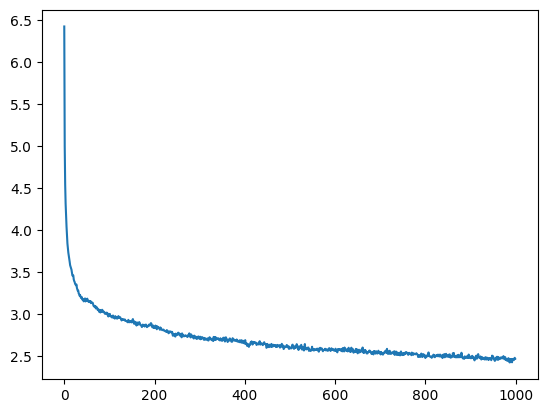

In [25]:
plt.plot(losses)

## 4. 文章を生成する

### 　4-1. 1つの形態素から文章を生成する関数を定義する

In [26]:
def make_sentence_from_one_word(morphemes, model, w2i_dic, i2w_dic):
  device = model.device
  model.eval()
  batch_size = 1

  l = len(w2i_dic) + 1
  eos = ['。', '！', '？']
  result = []

  with torch.no_grad(): # 勾配を計算して逆伝播しないことからこの記述で負荷を減らす
    for morpheme in morphemes:
      model.init_hidden(batch_size)
      sentence = morpheme
      id = [[w2i_dic[morpheme]]] # 入力した形態素を辞書でインデックス列に変換
      for idx in range(100):
        t = torch.tensor(id).to(device) # それをテンソルにする
        outputs = model(t)
        outputs = outputs.reshape(l)
        probs = torch.softmax(outputs, dim=0).cpu().detach().numpy() # 確率
        next_idx = np.random.choice(l, p=probs)
        next_morpheme = i2w_dic[next_idx]
        sentence += ' ' + next_morpheme
        if next_morpheme in eos:
          break
        id = [[w2i_dic[next_morpheme]]]
      result.append(sentence.replace(' ', ''))

  return result

### 　4-2. あらかじめ用意した形態素 (morpheme) で文章を生成してみる

In [34]:
morphemes = ['私', '下人', '昨日', '明日', '君', 'する', 'しかし', 'それ', 'いつ', '羅生門']
make_sentence_from_one_word(morphemes, model, w2i_dic, i2w_dic)

['私ゲエルは不思議なつこい夫人夫人は女していれの隣だった。',
 '下人は僕の知らへ顔だった。',
 '昨日には又の女の空の中にか急にひっそりを流した。',
 '明日に河童を捲いた後。',
 '君はそれぎり得といっに覚醒いたしも銀座。',
 'するとそこに乗ったのです。',
 'しかし僕はふとな歯車を信じています。',
 'それからちょっと消火栓も考えたものは皮膚に救いですか？',
 'いつはおのずから勢いを持ったまま、深い静かに包まの部屋ですぐ静かを落し出した。',
 '羅生門の降るの笑い声のうちを見た時に頭もかえっての日をはるか下を味わった。']

### 　4-3. ランダムに用意した形態素で文章を生成してみる

In [28]:
import random

In [29]:
# 作成した辞書（作品の中にある全単語集）のリストを作る
word_list = [key for key in w2i_dic.keys()]

# そのうち 10単語 を ten_words として用意する
ten_words = random.sample(word_list, 10)
print(ten_words)

# ten_words を形態素として文章を生成してみる
morphemes = [word for word in ten_words]
make_sentence_from_one_word(morphemes, model, w2i_dic, i2w_dic)

['さようなら', '星', 'ムッシウ', '腹巻', '頸', '勿体', '昂然', '舞いこん', '脂', '目下']


['さようならをあてたというものに従って来るのでございます。',
 '星になったのは銅貨だった。',
 'ムッシウだ？',
 '腹巻でございます。',
 '頸はだれことの湯屋ほどであることをもらしました。',
 '勿体も今は久しぶり神宮前の詩人ブランコをあい、中央線と存じました。',
 '昂然を？',
 '舞いこんはほんとう滅びん。',
 '脂の八犬犬伝たのももうというようにむくんをとっていました。',
 '目下もまた実際のことじゃげえせんかも飼っない。']

## その他

In [30]:
with open('akutagawa_dataset_w2i.txt', 'wt') as f:
  f.writelines([line + '\n' for line in word_list])

In [31]:
!cat /proc/uptime | awk '{printf("残り時間 : %.2f", 12-$1/60/60)}'

残り時間 : 11.75

In [32]:
# 作業用フォルダの作成
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p '/content/drive/My Drive/work/'
%cd '/content/drive/My Drive/work/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/work


In [33]:
torch.save(model.state_dict(), '/content/drive/MyDrive/230723_AIandML.pth')